In [1]:
import torch

In [2]:
saved_gate_path = [# "/home/wjbang/workspace/pMoE/pMoE/gate_data/enwik8_1000_20250115-213836.pt",
                   "/home/wjbang/workspace/pMoE/pMoE/gate_data/wikitext-2_1000_20250116-125819.pt",
                   "/home/wjbang/workspace/pMoE/pMoE/gate_data/squad_1000_20250116-142453.pt"]

In [3]:
from copy import deepcopy

def get_statistical_data(saved_gate_path, bsz=1, pipe_stage=2, top_k=2):
    '''
    Figure out the most imbalanced token distribution on each dataset
    Only compatible with the moe models with 64 experts
    '''
    final_record = []
    final_dataset_dist = []
    final_p_counts = []
    
    for path in saved_gate_path:
        dataset_stat = []
        dataset_dist = []
        p_count_board = []
        
        gate_data = torch.load(path)
        num_iters = len(gate_data)
        num_layers = len(gate_data[0])-2
        print(f"Number of iterations: {num_iters}")
        
        # Handling batch
        bsz_gate_data = []
        for start_id in range(0, num_iters, bsz):
            tmp = deepcopy(gate_data[start_id])
            end_id = max(start_id+bsz, num_iters)
            for layer_idx in range(1, num_layers+1):
                batch = []
                for element in range(start_id, end_id):
                    batch.append(gate_data[element][f'layer_{layer_idx}_gate'][:, :top_k])
                batch = torch.cat(batch, dim=0)
                tmp[f'layer_{layer_idx}_gate'] = batch
            bsz_gate_data.append(tmp)
        gate_data = bsz_gate_data
        
        num_iters = len(gate_data)
        num_layers = len(gate_data[0])-2
        print(f"Number of iterations after batching: {num_iters}")
                
        # Handling pipeline stage
        pp_gate_data = []
        for iter in range(num_iters):
            pp_data_tmp = []
            for n_pp in range(pipe_stage):
                pp_data_tmp.append(deepcopy(gate_data[iter]))
            for layer_idx in range(1, num_layers+1):
                tmp = gate_data[iter][f"layer_{layer_idx}_gate"]
                if tmp.shape[0] < pipe_stage:
                    raise ValueError("Pipe stage is larger than the number of items in a batch!!")
                splited_gate_val = torch.split(tmp, tmp.shape[0]//pipe_stage, dim=0)
                for n_pp in range(pipe_stage):
                    pp_data_tmp[n_pp][f"layer_{layer_idx}_gate"] = splited_gate_val[n_pp].to(torch.int32)
            pp_gate_data.extend(pp_data_tmp)
        
        gate_data = pp_gate_data
        num_iters = len(gate_data)
        num_layers = len(gate_data[0])-2
        
        print(f"Number of iterations after pipeline stage: {num_iters}")
            
        for iter in range(num_iters):
            for layer_idx in range(1, num_layers+1):
                batch = gate_data[iter][f"layer_{layer_idx}_gate"]
                batch = batch.reshape(1, -1).squeeze(0)
                batch = batch // 8
               
                counts = torch.bincount(batch, minlength=8)
                imbalance_level = counts.max() / counts.sum()
                p_counts = counts / counts.sum()
                stat_item = {
                    "stat": p_counts,
                    "imbalance": imbalance_level,
                    "layer_idx": layer_idx,
                    "batch_size": bsz,
                    "pipe_stage": pipe_stage
                }
                dataset_stat.append(stat_item)
                p_count_board.append(p_counts.tolist())
                
        max_imbalance = -1
        max_imbalance_item = None
        for item in dataset_stat:
            if item["imbalance"] > max_imbalance:
                max_imbalance = item["imbalance"]
                max_imbalance_item = item
            dataset_dist.append(item["imbalance"].cpu().item())
        final_record.append(max_imbalance_item)
        final_dataset_dist.append(dataset_dist)
        final_p_counts.append(p_count_board)
        
    return final_record, final_dataset_dist, final_p_counts

In [57]:
final_record, final_dataset_dist = get_statistical_data(saved_gate_path)

/tmp/ipykernel_1273432/1131020206.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gate_data = torch.load(path)


Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 2000
Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 2000
Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 2000


In [66]:
print(final_record[0])
print(final_record[1])
print(final_record[2])
print(max(final_dataset_dist[0]))
print(max(final_dataset_dist[1]))
print(max(final_dataset_dist[2]))

{'stat': tensor([0, 0, 3, 0, 0, 0, 0, 1], device='cuda:0'), 'imbalance': tensor(0.7500, device='cuda:0'), 'layer_idx': 3, 'batch_size': 1, 'pipe_stage': 2}
{'stat': tensor([  7,  36,  20, 108,  11,  27,  19,  54], device='cuda:0'), 'imbalance': tensor(0.3830, device='cuda:0'), 'layer_idx': 11, 'batch_size': 1, 'pipe_stage': 2}
{'stat': tensor([0, 8, 2, 1, 1, 0, 2, 0], device='cuda:0'), 'imbalance': tensor(0.5714, device='cuda:0'), 'layer_idx': 19, 'batch_size': 1, 'pipe_stage': 2}
0.75
0.38297873735427856
0.5714285969734192


In [67]:
import matplotlib.pyplot as plt

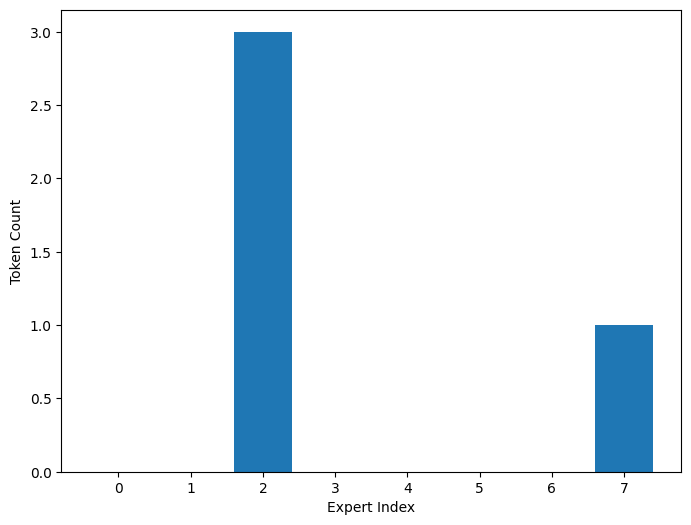

In [68]:
# enwik8
token_count = final_record[0]["stat"].cpu()
expert_idx = range(len(token_count))

plt.figure(figsize=(8, 6))
plt.bar(expert_idx, token_count)    
plt.title("")
plt.xlabel("Expert Index")
plt.ylabel("Token Count")
plt.xticks(expert_idx)

plt.show()

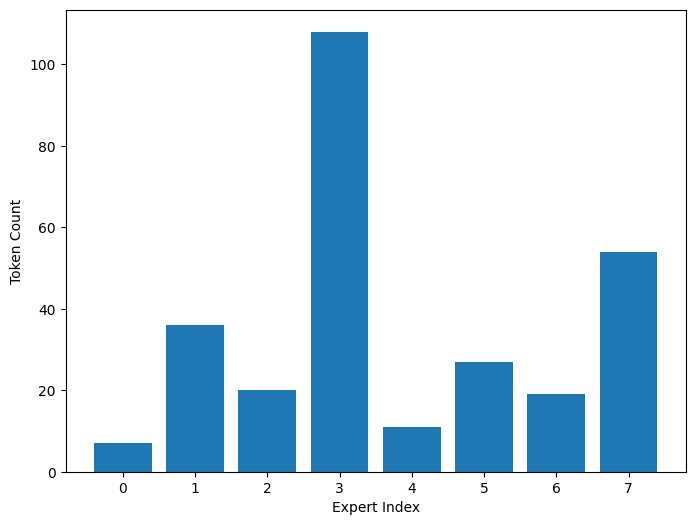

In [69]:
# wikitext-2
token_count = final_record[1]["stat"].cpu()
expert_idx = range(len(token_count))

plt.figure(figsize=(8, 6))
plt.bar(expert_idx, token_count)    
plt.title("")
plt.xlabel("Expert Index")
plt.ylabel("Token Count")
plt.xticks(expert_idx)

plt.show()

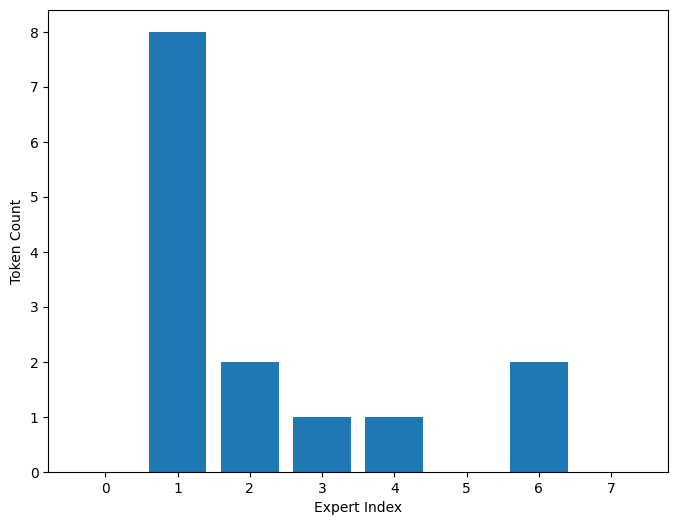

In [70]:
# SQUAD: question
token_count = final_record[2]["stat"].cpu()
expert_idx = range(len(token_count))

plt.figure(figsize=(8, 6))
plt.bar(expert_idx, token_count)    
plt.title("")
plt.xlabel("Expert Index")
plt.ylabel("Token Count")
plt.xticks(expert_idx)

plt.show()

In [76]:
_, pp1b1 = get_statistical_data(saved_gate_path, bsz=1, pipe_stage=1)
_, pp2b1 = get_statistical_data(saved_gate_path, bsz=1, pipe_stage=2)
_, pp4b1 = get_statistical_data(saved_gate_path, bsz=1, pipe_stage=4)

/tmp/ipykernel_1273432/1131020206.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gate_data = torch.load(path)


Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 1000
Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 1000
Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 1000
Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 2000
Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 2000
Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 2000
Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 4000
Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 4000
Number of iterations: 1000
Number of iterations after batching: 

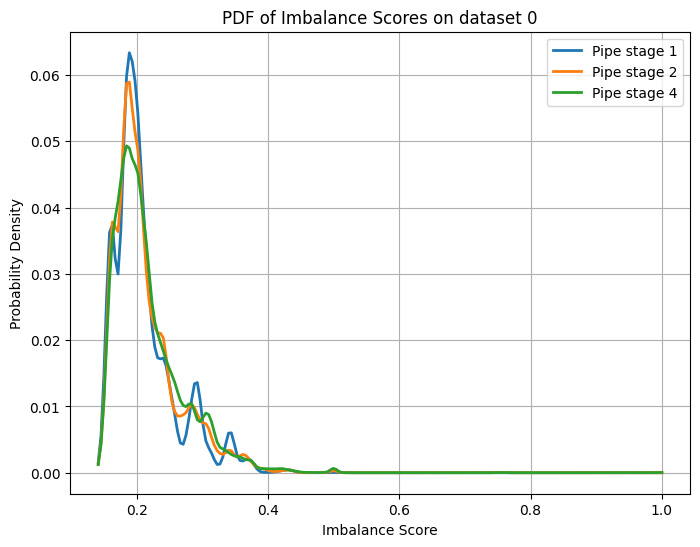

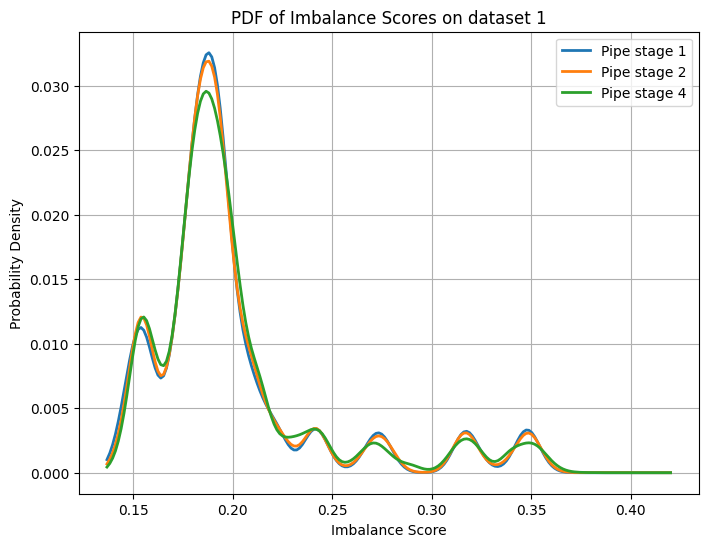

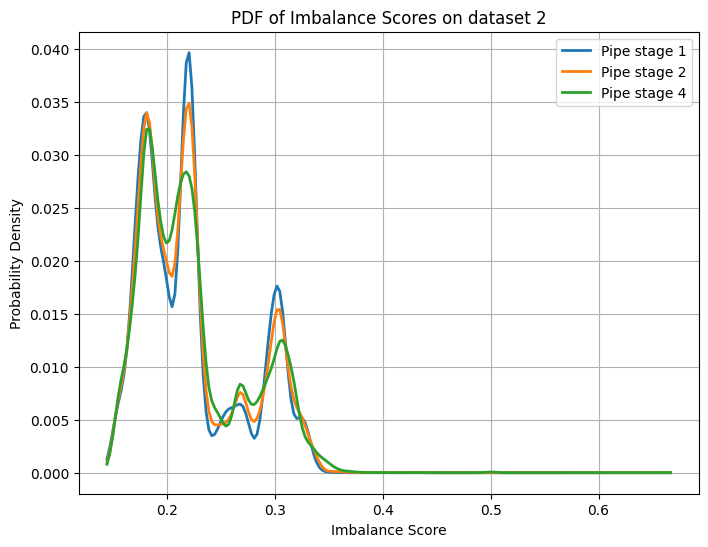

In [81]:
# Get the imbalance distribution
# bsz = 1
import numpy as np
from scipy.stats import gaussian_kde

for i in range(3):
    data_1 = pp1b1[i]
    data_2 = pp2b1[i]
    data_3 = pp4b1[i]
    
    # -- Prepare a combined range for x-values --
    # so all curves share the same horizontal scale
    combined_data = np.concatenate([data_1, data_2, data_3])
    x_min, x_max = np.min(combined_data), np.max(combined_data)
    x_vals = np.linspace(x_min, x_max, 200)  # 200 points for a smooth curve
    
    # -- Create KDE objects for each dataset --
    kde_1 = gaussian_kde(data_1)
    kde_2 = gaussian_kde(data_2)
    kde_3 = gaussian_kde(data_3)
    
    # Evaluate the density over x_vals
    pdf_1 = kde_1(x_vals)
    pdf_2 = kde_2(x_vals)
    pdf_3 = kde_3(x_vals)
    
    pdf_1 = pdf_1 / pdf_1.sum()
    pdf_2 = pdf_2 / pdf_2.sum()
    pdf_3 = pdf_3 / pdf_3.sum()
    
    # -- Plot each PDF on the same figure --
    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, pdf_1, label='Pipe stage 1', linewidth=2)
    plt.plot(x_vals, pdf_2, label='Pipe stage 2', linewidth=2)
    plt.plot(x_vals, pdf_3, label='Pipe stage 4', linewidth=2)
    
    plt.title(f"PDF of Imbalance Scores on dataset {i}")
    plt.xlabel("Imbalance Score")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [4]:
# Actual data for the paper
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# pp4b1t2 = get_statistical_data(saved_gate_path, bsz=1, pipe_stage=4, top_k=2)
pp4b1t1 = get_statistical_data(saved_gate_path, bsz=1, pipe_stage=4, top_k=1)

/tmp/ipykernel_3298002/2827361244.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gate_data = torch.load(path)


Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 4000
Number of iterations: 1000
Number of iterations after batching: 1000
Number of iterations after pipeline stage: 4000


In [7]:
print(len(pp4b1t1[2][1]))

108000


In [9]:
# concat all the items
p_count_list = []
for i in range(len(pp4b1t1[2][0])):
    p_count_list.append(pp4b1t1[2][0][i])
    p_count_list.append(pp4b1t1[2][1][i])

print(len(p_count_list))
n_items = len(p_count_list)
num_indices = 4000

indices = torch.randperm(n_items)[:num_indices]

# tensorize
p_count_tensor = torch.tensor(p_count_list)
p_count_tensor = p_count_tensor[indices]

print(p_count_tensor.shape)

216000
torch.Size([4000, 8])


In [10]:
# save it to csv file
import csv
p_count_csv = p_count_tensor.tolist()

csv_file = "p_count_selected.csv"
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(p_count_csv)

print(f"Data saved to {csv_file}")

Data saved to p_count_selected.csv


In [14]:
# Get the imbalance distribution (only top-1)
# Save the data to csv file
import csv

# 1. topk=2 wikitext and squad
with open('wikitext_squad_top1_dist.csv', mode='w') as file:
    writer = csv.writer(file)
    for i in range(len(pp4b1t1[2][0])):
        writer.writerow(pp4b1t1[2][0][i])
        writer.writerow(pp4b1t1[2][1][i])

KeyboardInterrupt: 

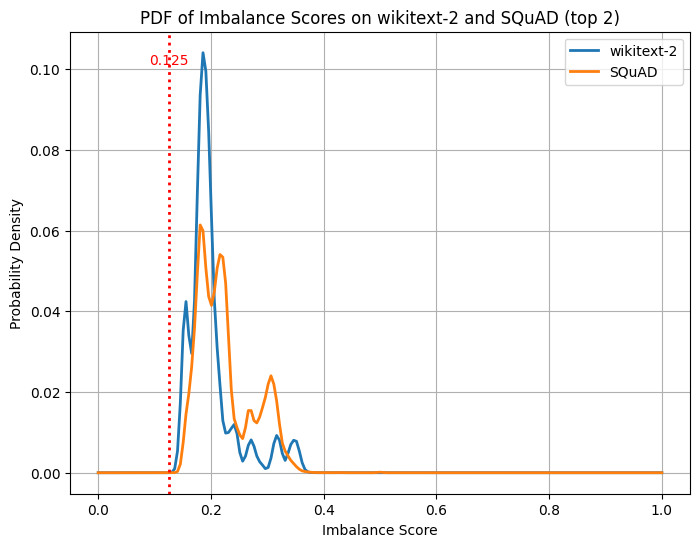

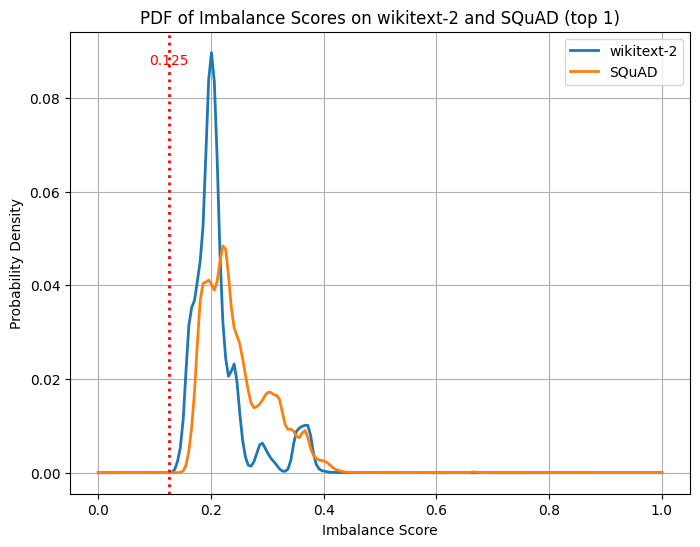

In [89]:
import numpy as np
from scipy.stats import gaussian_kde

for i in range(2):
    if i == 0:
        data_1 = pp4b1t2[1][1]
        data_2 = pp4b1t2[1][2]
        title_str = "PDF of Imbalance Scores on wikitext-2 and SQuAD (top 2)"
    else:
        data_1 = pp4b1t1[1][1]
        data_2 = pp4b1t1[1][2]
        title_str = "PDF of Imbalance Scores on wikitext-2 and SQuAD (top 1)"

    combined_data = np.concatenate([data_1, data_2])
    # Ensure we at least start at zero
    data_min = np.min(combined_data)
    data_max = np.max(combined_data)
    x_min = 0.0 if data_min > 0 else data_min  # if all data > 0, start at 0
    data_max = 1
    x_vals = np.linspace(x_min, data_max, 200)

    kde_1 = gaussian_kde(data_1)
    kde_2 = gaussian_kde(data_2)

    pdf_1 = kde_1(x_vals)
    pdf_2 = kde_2(x_vals)

    # You might prefer a *true* PDF normalization using the integral, e.g.:
    # pdf_1 /= np.trapz(pdf_1, x_vals)
    # pdf_2 /= np.trapz(pdf_2, x_vals)
    # (Below is sum-based, for demonstration only.)
    pdf_1 /= pdf_1.sum()
    pdf_2 /= pdf_2.sum()

    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, pdf_1, label='wikitext-2', linewidth=2)
    plt.plot(x_vals, pdf_2, label='SQuAD', linewidth=2)

    # 1) Add red vertical dotted line at 0.125
    plt.axvline(0.125, color='red', linestyle=':', linewidth=2)

    # 2) After plotting, get current y-limits so we can position the text.
    y_min, y_max = plt.ylim()
    # Place text slightly below the top (e.g. 95% of y_max)
    plt.text(
        0.125,         # x-position
        0.95 * y_max,  # y-position
        "0.125", 
        color='red',
        rotation=0,   # make the text vertical to match the line
        ha='center',
        va='top'
    )

    plt.title(title_str)
    plt.xlabel("Imbalance Score")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.show()

In [90]:
# Save the data to csv file
import csv

# 1. topk=2 wikitext and squad
with open('wikitext_squad_top2.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['wikitext-2', 'SQuAD'])
    for i in range(len(pp4b1t2[1][1])):
        writer.writerow([pp4b1t2[1][1][i], pp4b1t2[1][2][i]])
        
# 2. topk=1 wikitext and squad
with open('wikitext_squad_top1.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['wikitext-2', 'SQuAD'])
    for i in range(len(pp4b1t1[1][1])):
        writer.writerow([pp4b1t1[1][1][i], pp4b1t1[1][2][i]])

In [13]:
def get_hardcoded_gate_data(saved_gate_path):
    '''
    Get the hardcoded gate data
    Only compatible with the deepseek-ai/deepseek-moe-16b-base model
    '''
    final_record = []
    for path in saved_gate_path:
        gate_data = torch.load(path)
        num_iters = len(gate_data)
        num_layers = len(gate_data[0])-2
        hardcode_list = []
        for i in range(num_iters):
            item = {}
            item[0] = torch.randint(0, 8, (gate_data[i][f'layer_1_gate'].shape[0],))
            for layer_idx in range(1, num_layers+1):
                item[layer_idx] = gate_data[i][f'layer_{layer_idx}_gate'][:, 0] // 8 # top-1 idx
            hardcode_list.append(item)
        final_record.append(hardcode_list)
    
    return final_record

In [22]:
hardcoded_gate_data = get_hardcoded_gate_data(saved_gate_path)

/tmp/ipykernel_3771657/1096947229.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gate_data = torch.load(path)


In [32]:
# Save the data
import os
torch.save(hardcoded_gate_data, os.path.join("/home/wjbang/workspace/pMoE/pMoE/gate_data/analysis_results","hardcoded_gate_data.pt"))
torch.save(final_record, os.path.join("/home/wjbang/workspace/pMoE/pMoE/gate_data/analysis_results","statistical_data.pt"))